In [4]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
!jupyter labextension enable

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import arviz as az
import pandas as pd
import xarray as xr
import pymc as pm
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import preliz as pz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import pandas as pd
from scipy import stats
from scipy.special import expit as logistic

In [6]:
def exp_quad_kernel(x, knots, l=1):
    """
    Exponentiated quadratic kernel.
    """
    return np.array([np.exp(-(x-k)**2 / (2*l**2)) for k in knots])

In [7]:
data = np.array([-1, 0, 1, 2])  # np.random.normal(size=4)
cov = exp_quad_kernel(data, data, 1)

print(cov)

[[1.         0.60653066 0.13533528 0.011109  ]
 [0.60653066 1.         0.60653066 0.13533528]
 [0.13533528 0.60653066 1.         0.60653066]
 [0.011109   0.13533528 0.60653066 1.        ]]


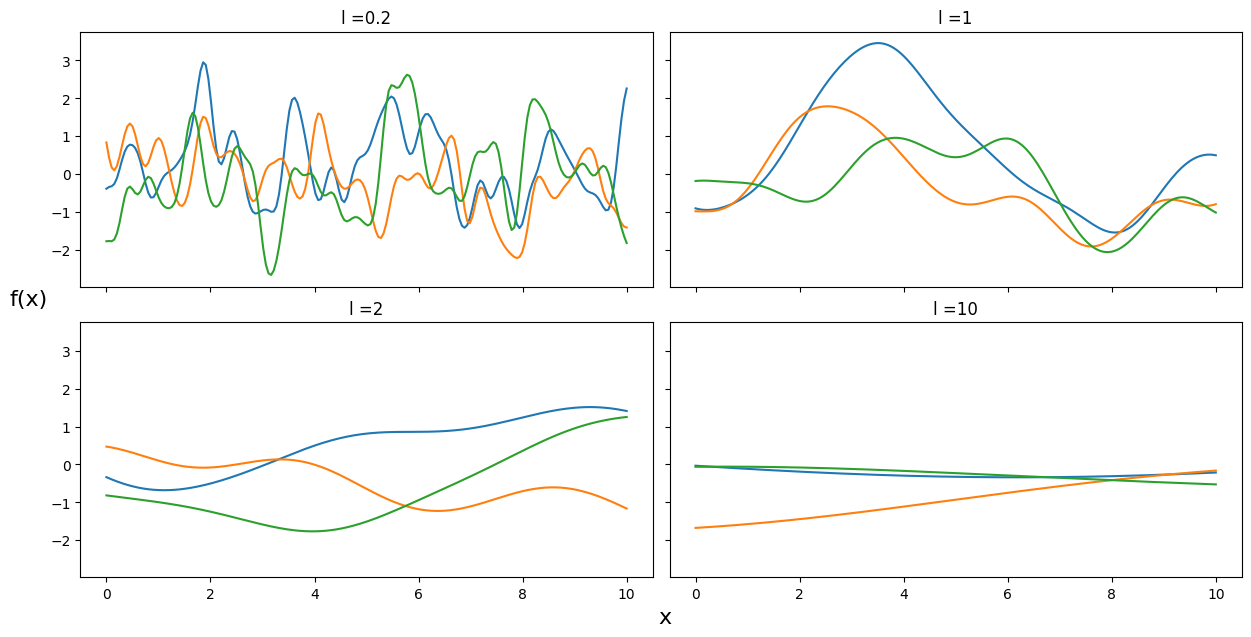

In [14]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True,
                       sharey=True, constrained_layout=True)
ax = np.ravel(ax)
num_examples = 3

for idx, l in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, l)
    y = stats.multivariate_normal.rvs(cov=cov, size=num_examples).T
    ax[idx].plot(test_points, y)
    ax[idx].set_title(f'l ={l}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16);

## Gaussian process regression

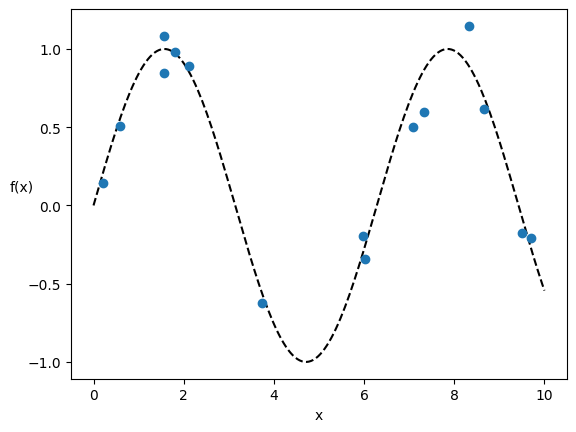

In [23]:
np.random.seed(42)
# Plot the true distribution.
true_x = np.linspace(0, 10, 200)
plt.plot(true_x, np.sin(true_x), 'k--')

# Sample points with noise.
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
plt.plot(x, y, 'o')

plt.xlabel('x')
plt.ylabel('f(x)', rotation=0);

In [36]:
# A one dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # Hyperprior for lengthscale kernel parameter
    l = pm.Gamma('l', 2, 0.5)
    # Instantiate a covariance function.
    cov = pm.gp.cov.ExpQuad(1, ls=l)
    # Instantiate a GP prior.
    gp = pm.gp.Marginal(cov_func=cov)
    # Prior on noise.
    eps = pm.HalfNormal('eps', 25)
    # Likelihood
    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, sigma=eps)
    trace_reg = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [l, eps]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


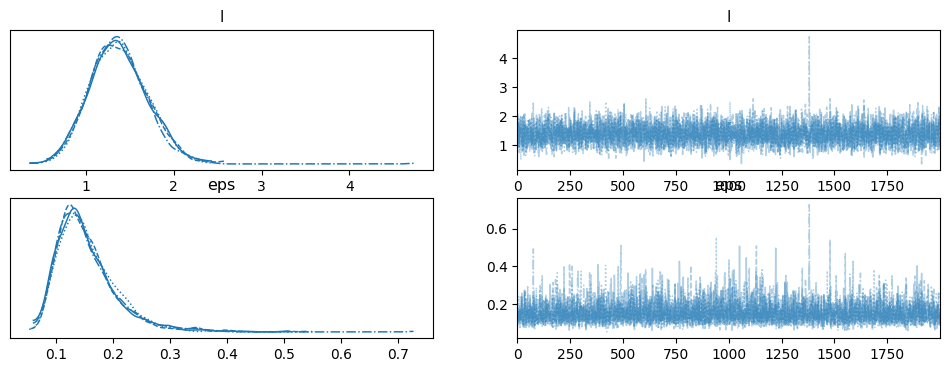

In [26]:
az.plot_trace(trace_reg);

In [40]:
# Generate 100 evenly spaced values between floor(min(x)) and ceil(max(x)).
# Reshape the result into a column vector for prediction input.
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:, None]

with model_reg:
    # If 'f_pred' already exists in the model, delete it to avoid duplication.
    if "f_pred" in model_reg:
        del model_reg.named_vars['f_pred']
    # Create a new GP conditional distribution for predictions at X_new.
    f_pred = gp.conditional('f_pred', X_new)

In [47]:
with model_reg:
    # Select the first 80 draws from the posterior trace for faster prediction.
    short_trace = trace_reg.sel(draw=slice(0, 80)) 
    # Sample from the posterior predictive distribution using the shortened trace.
    pred_samples = pm.sample_posterior_predictive(short_trace, var_names=["f_pred"])

Sampling: [f_pred]


Output()

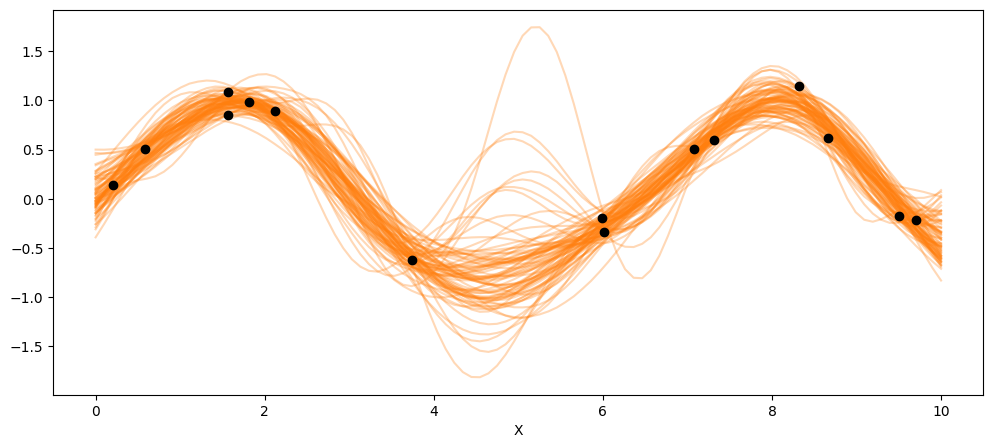

In [99]:
_, ax = plt.subplots(figsize=(12,5))
# TODO(gp): We should flatten.
values = pred_samples["posterior_predictive"]["f_pred"][2]
ax.plot(X_new, values.T, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X');

Text(0, 0.5, 'f(x)')

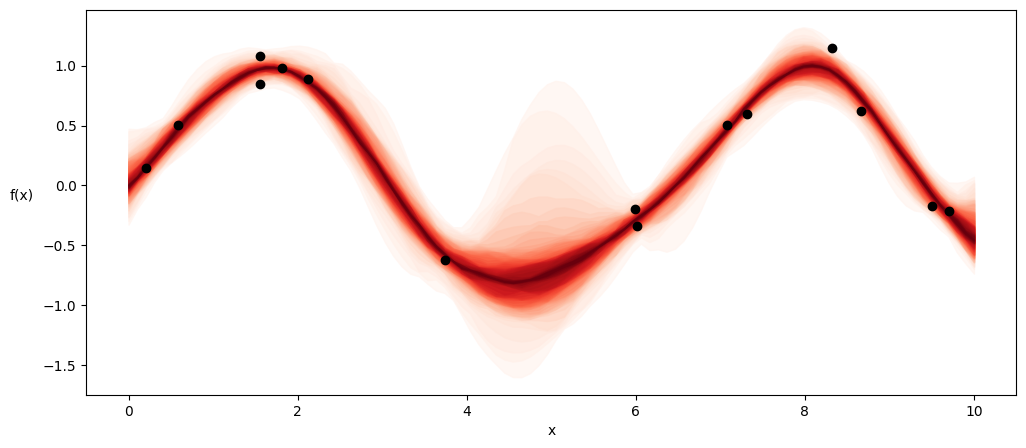

In [102]:
_, ax = plt.subplots(figsize=(12,5))
# Plot the distribution of Gaussian process predictions over new input points.
pm.gp.util.plot_gp_dist(ax, values, X_new, plot_samples=False);
# Plot the original training data as black dots for reference.
ax.plot(X, y, 'ko')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)

In [107]:
trace_reg["posterior"]["l"]

<xarray.DataArray 'l' (chain: 4, draw: 2000)> Size: 64kB
array([[1.09224876, 0.90122654, 0.92756413, ..., 1.32749539, 1.27800771,
        1.62865326],
       [1.51765471, 1.35308384, 1.35308384, ..., 1.60228829, 1.52964304,
        1.16915323],
       [1.58658509, 1.58658509, 1.40680699, ..., 1.57764929, 1.44314009,
        1.5787854 ],
       [1.35829496, 1.35829496, 1.56599765, ..., 1.0599855 , 1.42117782,
        1.51565453]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 16kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999

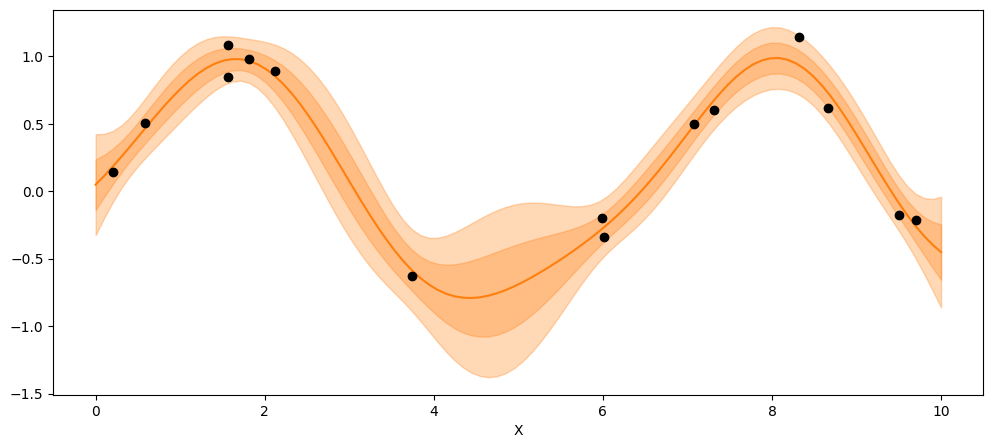

In [110]:
# plot the results
_, ax = plt.subplots(figsize=(12,5))

# predict
with model_reg:
    point = {'l': trace_reg["posterior"]['l'].mean(), 'eps': trace_reg["posterior"]['eps'].mean()}
    mu, var = gp.predict(X_new, point=point, diag=True)
    sd = var**0.5

# plot mean and 1σ and 2σ intervals
ax.plot(X_new, mu, 'C1')
ax.fill_between(X_new.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)

ax.fill_between(X_new.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X');

## Classification

In [117]:
dir_name = "/app/code/book.2018.Martin.Bayesian_Analysis_with_Python.2e"
iris = pd.read_csv(dir_name + '/data2/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [118]:
# Filter the DataFrame to include only 'setosa' and 'versicolor' species.
df = iris.query("species == ('setosa', 'versicolor')")

# Convert species labels to categorical integer codes (e.g., 0 and 1).
y = pd.Categorical(df['species']).codes

# Extract sepal length values as a 1D NumPy array.
x_1 = df['sepal_length'].values

# Reshape the 1D array to a 2D column vector for modeling input.
X_1 = x_1[:, None]

In [119]:
with pm.Model() as model_iris:
    # Define a Gamma prior for the lengthscale parameter in the covariance function.
    l = pm.Gamma('l', 2, 0.5)
    # Create an exponential quadratic (RBF) covariance function with the lengthscale.
    cov = pm.gp.cov.ExpQuad(1, l)
    # Define a latent Gaussian process using the specified covariance function.
    gp = pm.gp.Latent(cov_func=cov)
    # Place a GP prior over the latent function values at the input locations X_1.
    f = gp.prior("f", X=X_1)
    # Define a Bernoulli likelihood with a logistic link function over latent f.
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    # Sample from the posterior using 1 chain and 1000 samples without convergence checks.
    trace_iris = pm.sample(1000, chains=1, compute_convergence_checks=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [l, f_rotated_]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 18 seconds.
